## Spiral dataset

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

def make_spiral_dataset(
    n_samples: int = 100,
    noise: float = 0.2,
    seed: int = None,
    x_range: Tuple[int, int] = (-1, 1),
    y_range: Tuple[int, int] = (-1, 1)
):
    # Install the random seed
    if seed:
        np.random.seed(seed)

    n = n_samples // 2  # Split samples between two spirals

    # Generate first spiral
    theta1 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r1 = 2 * theta1 + np.pi
    x1 = np.stack([r1 * np.cos(theta1), r1 * np.sin(theta1)], axis=1)

    # Generate second spiral
    theta2 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r2 = -2 * theta2 - np.pi
    x2 = np.stack([r2 * np.cos(theta2), r2 * np.sin(theta2)], axis=1)

    # Combine spirals and add noise
    X = np.vstack([x1, x2])
    X += np.random.randn(n_samples, 2) * noise

    # Scale X to fit within the specified x and y ranges
    X[:, 0] = np.interp(X[:, 0], (X[:, 0].min(), X[:, 0].max()), x_range)
    X[:, 1] = np.interp(X[:, 1], (X[:, 1].min(), X[:, 1].max()), y_range)

    # Create labels
    y_range = np.zeros(n_samples)
    y_range[:n] = 0  # First spiral
    y_range[n:] = 1  # Second spiral

    return X, y_range


## Visualize Dataset

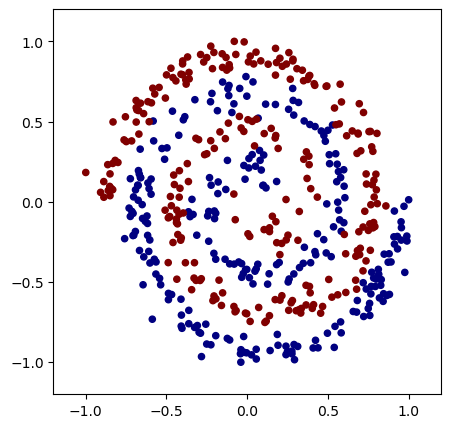

In [29]:
# Generate synthetic classification data
n_samples = 500

# Usage example:
x, y_target = make_spiral_dataset(n_samples=n_samples, noise=1.5, seed=1)

y_target = y_target.reshape(-1, 1)

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], c=y_target, s=20, cmap="jet")
plt.xlim(x[:, 0].min() - 0.2, x[:, 0].max() + 0.2)
plt.ylim(x[:, 1].min() - 0.2, x[:, 1].max() + 0.2)
plt.show()

## Fail of the Single Linear Layer

In [30]:
from dataclasses import dataclass
from typing import List, Literal


@dataclass
class Parameter:
    name: str
    data: np.ndarray
    grad: np.ndarray


class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def parameters(self) -> List[Parameter]:
        return []
    
    def zero_grad(self):
        for param in self.parameters():
            param.grad.fill(0)


# Define a custom type alias for initialization methods
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]

def parameter(
    input_size: int,
    output_size: int,
    init_method: InitMethod = "xavier",
    gain: float = 1,
    alpha: float = 0.01
) -> np.ndarray:
    weights = np.random.randn(input_size, output_size)

    if init_method == "xavier":
        std = gain * np.sqrt(1.0 / input_size)
        return std * weights
    if init_method == "he":
        std = gain * np.sqrt(2.0 / input_size)
        return std * weights
    if init_method == "he_leaky":
        std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / input_size))
        return std * weights
    if init_method == "normal":
        return gain * weights
    if init_method == "uniform":
        return gain * np.random.uniform(-1, 1, size=(input_size, output_size))

    raise ValueError(f"Unknown initialization method: {init_method}")


class Linear(Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        init_method: InitMethod = "xavier"
    ):
        self.input: np.ndarray = None

        self.weights: np.ndarray = parameter(input_size, output_size, init_method)
        self.d_weights: np.ndarray = np.zeros_like(self.weights)

        self.biases: np.ndarray = np.zeros((1, output_size))
        self.d_biases: np.ndarray = np.zeros_like(self.biases)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        x1 = x @ self.weights + self.biases
        return x1
    
    def backward(self, d_out: np.ndarray) -> np.ndarray:
        self.d_weights = self.input.T @ d_out
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)

        return d_out @ self.weights.T

    def parameters(self):
        return [
            Parameter(
                name="weights",
                data=self.weights,
                grad=self.d_weights
            ),
            Parameter(
                name="biases",
                data=self.biases,
                grad=self.d_biases
            ),
        ]
    

class BCELoss(Module):
    def forward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:        
        loss = -(
            target * np.log(pred + epsilon) + 
            (1 - target) * np.log(1 - pred + epsilon)
        )

        return np.mean(loss)

    def backward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:
        grad = (pred - target) / (pred * (1 - pred) + epsilon)
        return grad


class Sigmoid(Module):
    def forward(self, x: np.ndarray):
        # Apply the Sigmoid function element-wise
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_out: np.ndarray):
        # Derivative of the Sigmoid function: sigmoid * (1 - sigmoid)
        ds = self.output * (1 - self.output)
        return d_out * ds


class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = self.momentum * self.velocity[param_id] - self.lr * grad

            # Update parameters
            param.data += self.velocity[param_id]


# Define function for plotting decision boundaries
def plot_decision_boundaries(model, X, y, bins=500):
    # Set the limits of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, bins), np.linspace(y_min, y_max, bins))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get the predicted class for each point in the grid
    Z = model.forward(grid)  # Only get the predicted output
    Z = (Z > 0.5).astype(int)  # Assuming binary classification

    # Reshape the predictions back to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', s=30, label='Data Points')
    plt.title('Decision Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

## Single Layer Model 

In [31]:
model = Linear(input_size=2, output_size=1, init_method="xavier")
activation = Sigmoid()
bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)

In [32]:
n_epoch = 100

for epoch in range(n_epoch):
    # Forward
    output = model(x)
    y_pred = activation(output)
    loss = bce(y_pred, y_target)

    model.zero_grad()

    # Backward
    grad = bce.backward(y_pred, y_target)
    grad = activation.backward(grad)
    model.backward(grad)

    optimizer.step(model)

    print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.6395
Epoch 1, Loss: 0.6352
Epoch 2, Loss: 0.6320
Epoch 3, Loss: 0.6317
Epoch 4, Loss: 0.6339
Epoch 5, Loss: 0.6358
Epoch 6, Loss: 0.6346
Epoch 7, Loss: 0.6326
Epoch 8, Loss: 0.6318
Epoch 9, Loss: 0.6321
Epoch 10, Loss: 0.6329
Epoch 11, Loss: 0.6330
Epoch 12, Loss: 0.6322
Epoch 13, Loss: 0.6318
Epoch 14, Loss: 0.6318
Epoch 15, Loss: 0.6320
Epoch 16, Loss: 0.6320
Epoch 17, Loss: 0.6316
Epoch 18, Loss: 0.6314
Epoch 19, Loss: 0.6316
Epoch 20, Loss: 0.6317
Epoch 21, Loss: 0.6316
Epoch 22, Loss: 0.6313
Epoch 23, Loss: 0.6311
Epoch 24, Loss: 0.6312
Epoch 25, Loss: 0.6314
Epoch 26, Loss: 0.6315
Epoch 27, Loss: 0.6313
Epoch 28, Loss: 0.6310
Epoch 29, Loss: 0.6310
Epoch 30, Loss: 0.6311
Epoch 31, Loss: 0.6313
Epoch 32, Loss: 0.6312
Epoch 33, Loss: 0.6311
Epoch 34, Loss: 0.6310
Epoch 35, Loss: 0.6310
Epoch 36, Loss: 0.6311
Epoch 37, Loss: 0.6311
Epoch 38, Loss: 0.6311
Epoch 39, Loss: 0.6310
Epoch 40, Loss: 0.6310
Epoch 41, Loss: 0.6310
Epoch 42, Loss: 0.6310
Epoch 43, Loss: 0.631

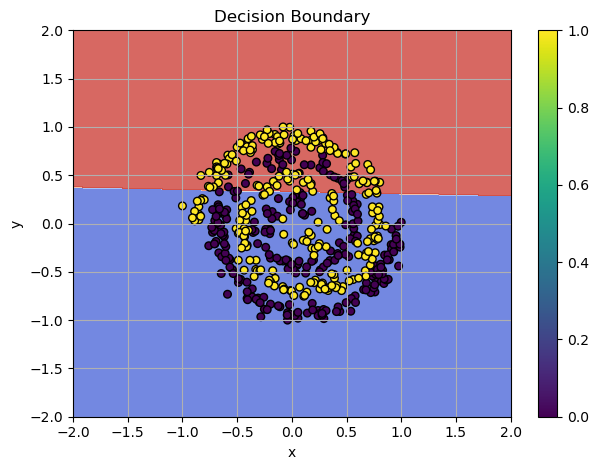

In [33]:
plot_decision_boundaries(model, x, y_target)

## Multi-Layer Network

In [34]:
from typing import List


class LeakyReLU(Module):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def forward(self, x: np.ndarray):
        self.input = x
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, d_out: np.ndarray):
        dx = np.ones_like(self.input)
        dx[self.input <= 0] = self.alpha
        return d_out * dx


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, d_out: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out
    
    def parameters(self) -> List[Parameter]:
        params = []
        for i, layer in enumerate(self.layers):
            for param in layer.parameters():
                # Add unique prefix name for optimization step
                param.name = f"layer_{i}_{param.name}"
                params.append(param)
        return params


## Multi-Layer model

In [63]:
# Model architecture
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.001, momentum=0.9)

In [64]:
n_epoch = 1000

for epoch in range(n_epoch):
    # Forward
    y_pred = model(x)
    loss = bce(y_pred, y_target)

    model.zero_grad() 

    # Backward
    grad = bce.backward(y_pred, y_target)
    model.backward(grad)

    optimizer.step(model)

    print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.7561
Epoch 1, Loss: 0.6769
Epoch 2, Loss: 0.6555
Epoch 3, Loss: 0.6653
Epoch 4, Loss: 0.6509
Epoch 5, Loss: 0.6272
Epoch 6, Loss: 0.6514
Epoch 7, Loss: 0.6507
Epoch 8, Loss: 0.6307
Epoch 9, Loss: 0.6251
Epoch 10, Loss: 0.6244
Epoch 11, Loss: 0.6325
Epoch 12, Loss: 0.6244
Epoch 13, Loss: 0.6225
Epoch 14, Loss: 0.6183
Epoch 15, Loss: 0.6191
Epoch 16, Loss: 0.6134
Epoch 17, Loss: 0.6124
Epoch 18, Loss: 0.6090
Epoch 19, Loss: 0.6082
Epoch 20, Loss: 0.6068
Epoch 21, Loss: 0.6047
Epoch 22, Loss: 0.6022
Epoch 23, Loss: 0.5971
Epoch 24, Loss: 0.5967
Epoch 25, Loss: 0.5955
Epoch 26, Loss: 0.5913
Epoch 27, Loss: 0.5893
Epoch 28, Loss: 0.5881
Epoch 29, Loss: 0.5852
Epoch 30, Loss: 0.5825
Epoch 31, Loss: 0.5809
Epoch 32, Loss: 0.5784
Epoch 33, Loss: 0.5761
Epoch 34, Loss: 0.5747
Epoch 35, Loss: 0.5731
Epoch 36, Loss: 0.5733
Epoch 37, Loss: 0.5765
Epoch 38, Loss: 0.5845
Epoch 39, Loss: 0.6336
Epoch 40, Loss: 0.6331
Epoch 41, Loss: 0.7295
Epoch 42, Loss: 0.5702
Epoch 43, Loss: 0.768

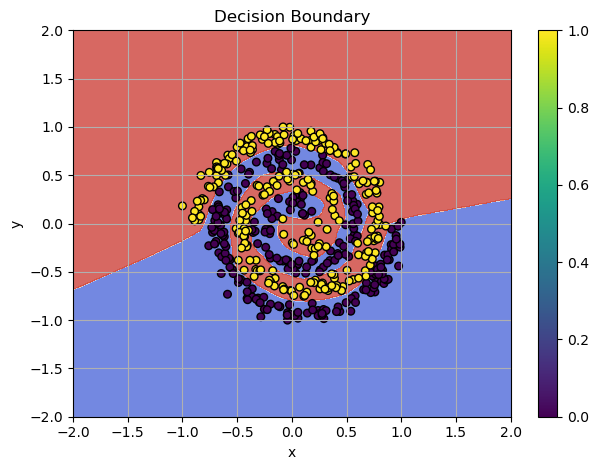

In [65]:
plot_decision_boundaries(model, x, y_target)